**Author**: J W Debelius<br/>
**Date**: 17 August 2015<br/>
**virtualenv**: power play

In [1]:
%%javascript
IPython.load_extensions('calico-spell-check', 'calico-document-tools')

<IPython.core.display.Javascript object>

# Number of iterations

The purpose of this notebook is to simulate the number of iterations required to collapase power onto a central limit theorm by varying two parameters, `num_runs` and `num_iter`. The `num_iter` refers to the number of tests performed, and then combined to calculate the power. The `num_runs` determines how many of these emperical power values are averaged for the effect size calculation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skbio
import scipy
import skbio

import absloute_power.utils as ap

from matplotlib import rcParams
from skbio.stats.power import subsample_power
import absloute_power.utils as ap

We'll also set it up so that anything that is plotted here is plotted using Helvetica.

In [2]:
# Sets up plotting parameters so that the default setting is use to Helvetica
# in plots
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica', 'Arial']
rcParams['text.usetex'] = True


We'll also set a random seed, so that hte values that come out are consistent.

In [3]:
np.random.seed(25)

We'll start by simulating a pair of distributions which we can test with a two-sample t test.

In [4]:
# Defines the test
def practice_test(samples):
    return scipy.stats.ttest_ind(samples[0], samples[1])[1]

# Defines the sample
sample1 = np.random.randn(1000) * 5 + 2.5
sample2 = np.random.randn(1000) * 5 + 0

# Tests the over all distributions
practice_test([sample1, sample2])

4.5772604874411524e-30

Let's vary the number of samples that we iterate over, between 10 and 5000 tests per iteration. We'll do 100 runs, and use that to calculate the power.

In [5]:
num_iter = [10, 50, 100, 500, 1000, 5000]
num_runs = 100
power = []

for ni in num_iter:
    power.append(
        subsample_power(practice_test,
                        [sample1, sample2],
                        min_counts=10,
                        max_counts=40,
                        counts_interval=10,
                        num_runs=num_runs,
                        num_iter=ni)
    )
    print ni

10
50
100
500
1000
5000


Now, let's convert the power to effect size, using statsmodels. This is what we typically use when the data is underpowered.

In [6]:
effs = []
for (pwr, cnt) in power:
    eff = []
    for i, r in enumerate(pwr):
        try:
            eff.append(ap.z_effect(counts=cnt, power=r))
        except:
            eff.append(np.array([1, 1, 1])*np.nan)
    effs.append(eff)
    

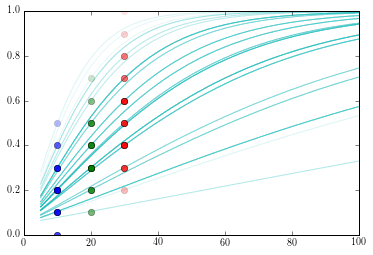

In [7]:
% matplotlib inline
pwr, cnt = power[0]
cnt2 = np.ones((100, 1)) * np.expand_dims(cnt, 0)
ax = plt.axes()
ax.set_xlim([0, 100])
ax.set_ylim([0, 1])
eff = effs[0]
for e in np.hstack(eff):
    ax.plot(np.arange(5, 105, 2.5), ap.z_power(np.arange(5, 105, 2.5), e), 'c-', alpha=0.05)
ax.plot(cnt2, pwr, 'o', alpha=0.1)

Finally, we're going to put together a set of plots. We'll define a set of helper functions to let us manipulate the effect size results, and then to plot them.

In [13]:
color1 = np.array([0.45, 0.45, 0.45])
def all_e(eff):
    """Gets all the effect size values"""
    flat = np.hstack(eff)
    return flat[np.isnan(flat) == False]

def calc_e(eff, num_draws=3, runs=25):
    """..."""
    flat = np.array([
        np.nanmean(np.random.choice(np.hstack(eff), num_draws))
        for i in xrange(runs)
        ])
    return flat[np.isnan(flat) == False]

def plot_e(ax, e, counts, pwr_alpha=0.05, color=color1, opac=0.1):
    ax.plot(counts,
            ap.z_power(counts, e, alpha=pwr_alpha), 
            '-',
            color=color,
            alpha=opac,
            linewidth=0.5)

def plot_mean(ax, eff, counts):
    ax.plot(counts, ap.z_power(counts, np.nanmean(eff), 0.05), 'r-', linewidth=0.5)

We'll also define parameters for plotting the data. We'll plot 100 iterations for each set, with values betwen 2 and 100. The critical value is 0.05. We'll combined data for 1, 3, 5, 10, and 25 sets of runs.

In [14]:
counts = np.arange(2.5, 101, 2.5)
runs = 100
alpha = 0.05
fs=10

num_draws = [(1, all_e), 
             (3, lambda x: calc_e(x, 3, runs)),
             (5, lambda x: calc_e(x, 5, runs)),
             (10, lambda x: calc_e(x, 10, runs)),
             (25, lambda x: calc_e(x, 25, runs)),
            ]

Finally, we'll plot the data.

In [15]:
counts

array([   2.5,    5. ,    7.5,   10. ,   12.5,   15. ,   17.5,   20. ,
         22.5,   25. ,   27.5,   30. ,   32.5,   35. ,   37.5,   40. ,
         42.5,   45. ,   47.5,   50. ,   52.5,   55. ,   57.5,   60. ,
         62.5,   65. ,   67.5,   70. ,   72.5,   75. ,   77.5,   80. ,
         82.5,   85. ,   87.5,   90. ,   92.5,   95. ,   97.5,  100. ])

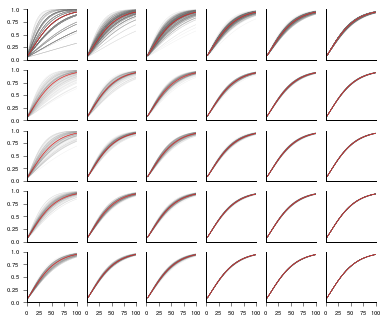

In [29]:
% matplotlib inline
mean_eff = np.zeros((len(num_iter), len(num_draws)))
std_eff = np.zeros((len(num_iter), len(num_draws)))

fig1 = plt.figure()
fig1.set_size_inches((6.25, 5.25))

for idy, eff in enumerate(effs):
    for idx, (num_draw, f_) in enumerate(num_draws):
        eff = np.hstack(eff)
        
        fn = '/Users/jwdebelius/Desktop/power_figs/iter/images/%i_runs_%i_iter.pdf' % (num_draw, num_iter[idy])
        
        ef2 = f_(eff)
        
        mean_eff[idy, idx] = ef2.mean()
        std_eff[idy, idx] = ef2.std() / np.sqrt(len(ef2))
        # Creates the summary figure for the notebook
        ax1 = fig1.add_subplot(5, 6, idx * 6 + idy + 1)
        for e in ef2:
            plot_e(ax1, e, counts, alpha, opac=0.1)
        plot_mean(ax1, eff, counts)
        ax1.set_xticks(np.arange(0, 101, 25))
        ax1.set_yticks(np.arange(0, 1.1, 0.25))
        # Cleans up the axis
        ap.format_ax(ax1,
                     xlim=[0, 100], 
                     ylim=[0, 1], 
                     show_x=(idx==4),
                     show_y=(idy==0),
                     xticks=np.arange(0, 101, 25),
                     yticks=np.arange(0, 1.1, 0.25),
                     fontsize1=6)
        ax1.spines['right'].set_visible(False)
        ax1.spines['top'].set_visible(False)
        ax1.yaxis.set_ticks_position('left')
        ax1.xaxis.set_ticks_position('bottom')
        if idx == 4:
            ax1.get_xaxis().set_tick_params(direction='out')
        else:
            ax1.get_xaxis().set_tick_params(tick1On=False, tick2On=False)
        if idy == 0:
            ax1.get_yaxis().set_tick_params(direction='out')
        else:
            ax1.get_yaxis().set_tick_params(tick1On=False, tick2On=False)
        
fig1.savefig('/Users/jwdebelius/Desktop/iter.pdf')

In [22]:
help(ax1.get_yaxis().set_tick_params)

Help on method set_tick_params in module matplotlib.axis:

set_tick_params(self, which=u'major', reset=False, **kw) method of matplotlib.axis.YAxis instance
    Set appearance parameters for ticks and ticklabels.
    
    For documentation of keyword arguments, see
    :meth:`matplotlib.axes.Axes.tick_params`.



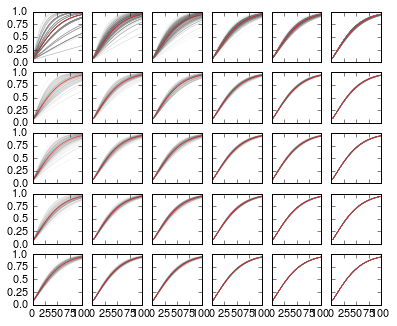

In [17]:
#         # Creates the individual figures for latex
#         fig2 = plt.figure()
#         fig2.set_size_inches(2.5/0.95, 2.5/0.95)
#         ax2 = fig2.add_axes((0.05, 0.05, 0.9, 0.9))
#         for e in ef2:
#             plot_e(ax2, e, counts, alpha, opac=0.05)
#         plot_mean(ax2, eff, counts)
#         ax2.set_xticks(np.arange(0, 101, 25))
#         ax2.set_yticks(np.arange(0, 1.1, 0.25))
#         ap.format_ax(ax2,
#                      fig=fig2,
#                      xlim=[0, 100], 
#                      ylim=[0, 1], 
#                      show_x=(idx==4),
#                      show_y=(idy==0),
#                      xticks=np.arange(0, 101, 25),
#                      yticks=np.arange(0, 1.1, 0.25),
#                      fontsize1=20
#                      )
#         fig2.savefig(fn)
#         plt.close(fig2)
        

The data starts to collapse with 1000 samples at 5 points, or 500 iterations at 10 points. So, 5000 seems like the magic number of iterations with this data.

In [13]:
num_iter

[10, 50, 100, 500, 1000, 5000]

In [14]:
num_draws

[(1, <function __main__.all_e>),
 (3, <function __main__.<lambda>>),
 (5, <function __main__.<lambda>>),
 (10, <function __main__.<lambda>>),
 (25, <function __main__.<lambda>>)]

In [15]:
for m_r, s_r in zip(*(mean_eff, std_eff)):
    for i, (m_, s_) in enumerate(zip(*(m_r, s_r))):
        print num_draws[i][0], m_, '[', m_ - s_, ', ', m_ + s_, ']', s_
    print ''

1 0.505301584733 [ 0.497228225437 ,  0.51337494403 ] 0.00807335929632
3 0.502678337327 [ 0.494658196771 ,  0.510698477883 ] 0.00802014055568
5 0.500262566142 [ 0.493729751235 ,  0.506795381049 ] 0.00653281490661
10 0.502121047823 [ 0.497676956134 ,  0.506565139512 ] 0.00444409168906
25 0.505166969363 [ 0.502783081964 ,  0.507550856761 ] 0.00238388739866

1 0.507418439768 [ 0.503885361645 ,  0.510951517892 ] 0.00353307812365
3 0.508969496574 [ 0.505622959501 ,  0.512316033646 ] 0.00334653707241
5 0.504475569583 [ 0.501464282287 ,  0.507486856878 ] 0.00301128729535
10 0.509537419234 [ 0.507504055801 ,  0.511570782666 ] 0.0020333634329
25 0.506198885038 [ 0.504910303395 ,  0.507487466681 ] 0.00128858164286

1 0.501584098491 [ 0.498739050884 ,  0.504429146098 ] 0.00284504760679
3 0.501563628766 [ 0.498723267949 ,  0.504403989584 ] 0.00284036081753
5 0.503869483695 [ 0.501503828036 ,  0.506235139354 ] 0.00236565565886
10 0.503691095573 [ 0.502015645912 ,  0.505366545235 ] 0.00167544966174
2

In [16]:
print mean_eff

[[ 0.50530158  0.50267834  0.50026257  0.50212105  0.50516697]
 [ 0.50741844  0.5089695   0.50447557  0.50953742  0.50619889]
 [ 0.5015841   0.50156363  0.50386948  0.5036911   0.50124277]
 [ 0.50111854  0.5014923   0.50123166  0.49970246  0.50082749]
 [ 0.50243436  0.50234825  0.50322826  0.50228406  0.50266099]
 [ 0.50358748  0.503628    0.50360995  0.50344489  0.50341965]]


In [17]:
print mean_eff - std_eff

[[ 0.49722823  0.4946582   0.49372975  0.49767696  0.50278308]
 [ 0.50388536  0.50562296  0.50146428  0.50750406  0.5049103 ]
 [ 0.49873905  0.49872327  0.50150383  0.50201565  0.50035858]
 [ 0.49977607  0.50008187  0.5002463   0.49890214  0.50030545]
 [ 0.50151875  0.50129474  0.50255795  0.50176064  0.50234659]
 [ 0.50307013  0.50309978  0.50321046  0.50312958  0.50325732]]


In [18]:
print mean_eff + std_eff

[[ 0.51337494  0.51069848  0.50679538  0.50656514  0.50755086]
 [ 0.51095152  0.51231603  0.50748686  0.51157078  0.50748747]
 [ 0.50442915  0.50440399  0.50623514  0.50536655  0.50212696]
 [ 0.502461    0.50290273  0.50221702  0.50050279  0.50134953]
 [ 0.50334996  0.50340175  0.50389857  0.50280748  0.50297539]
 [ 0.50410483  0.50415623  0.50400945  0.5037602   0.50358197]]


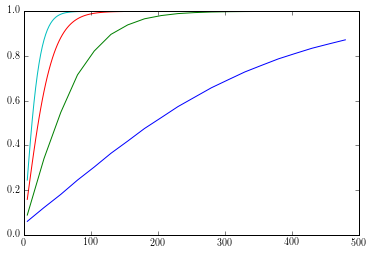

In [19]:
plt.plot(np.arange(5, 500, 25), ap.z_power(np.arange(5, 500, 25), 0.2), 'b')
plt.plot(np.arange(5, 500, 25), ap.z_power(np.arange(5, 500, 25), 0.4), 'g')
plt.plot(np.arange(5, 150, 2.5), ap.z_power(np.arange(5, 150, 2.5), 0.6), 'r')
plt.plot(np.arange(5, 150, 2.5), ap.z_power(np.arange(5, 150, 2.5), 0.8), 'c')